In [1]:
import numpy as np
from numpy.linalg.linalg import norm
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow as tf
#from tensorflow.keras.models import Model
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization
#from keras.optimizers import Adam
#from keras.optimizers import RMSprop
#from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeaturel
import pandas as pd


# データの読み込み
data = np.load('/home/maeda/data/bsiso_eeof/prepro_anomaly_7vals.npz')
print('data = ', data.files)

data =  ['lat', 'lon', 'time', 'real_time', 'olr', 'u850', 'v850', 'u200', 'v200', 'h850', 'pr_wtr']


In [14]:
lat = data['lat'][24:49]
lon = data['lon']
olr = data['olr'][80:-435,24:49,:]
u850 = data['u850'][80:-435,24:49,:]
v850 = data['v850'][80:-435,24:49,:]
u200 = data['u200'][80:-435,24:49,:]
v200 = data['v200'][80:-435,24:49,:]
h850 = data['h850'][80:-435,24:49,:]
pr_wtr = data['pr_wtr'][80:-435,24:49,:]
time = data['time'][80+10:-435]  # 射影後にデータが10日進むため、時刻の方を前進させておく
real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
print(lat.shape, lon.shape, olr.shape, u850.shape, v850.shape, u200.shape, v200.shape, h850.shape, pr_wtr.shape)
print(real_time[0], real_time[-1])

(25,) (144,) (15556, 25, 144) (15556, 25, 144) (15556, 25, 144) (15556, 25, 144) (15556, 25, 144) (15556, 25, 144) (15556, 25, 144)
1979-04-01 00:00:00 2021-10-22 00:00:00


In [3]:
# 標準化処理
def normalization(data):
  data_mean = np.mean(data, axis=0)
  data_std  = np.std(data, axis=0)
  data_norm = (data - data_mean) / data_std
  print('Raw Data        = ', data.max(), data.min())
  print('Normalized Data = ', data_norm.max(), data_norm.min())
  del data_mean, data_std
  return data_norm

olr_norm  = normalization(olr)
u850_norm = normalization(u850)
v850_norm = normalization(v850)
u200_norm = normalization(u200)
v200_norm = normalization(v200)
h850_norm = normalization(h850)
pr_wtr_norm = normalization(pr_wtr)

Raw Data        =  110.6346296477856 -163.06319252604578
Normalized Data =  8.556107636550504 -15.60639096571602
Raw Data        =  26.628822697430984 -27.39433673019417
Normalized Data =  8.721299953096503 -6.642175286596695
Raw Data        =  19.607371330660023 -21.027599307874095
Normalized Data =  9.328358359891899 -9.213922302694371
Raw Data        =  54.12790452689419 -59.46183253683652
Normalized Data =  6.5724703942417575 -8.20258372433285
Raw Data        =  50.62647740730578 -45.80567673624702
Normalized Data =  7.335033696704782 -6.9601182731582485
Raw Data        =  132.37072580688695 -196.37969980408127
Normalized Data =  5.493621549709639 -9.488428586088496
Raw Data        =  36.488246148282585 -32.8364699960708
Normalized Data =  8.017584154484192 -6.667295831610776


In [51]:
# bsiso index (eEOF) 読み込み
data_file = '/home/maeda/archive/kikuchi_bsiso_index.dat'

year    = np.loadtxt(data_file, usecols = 0, dtype = int)
month   = np.loadtxt(data_file, usecols = 1, dtype = int)
day     = np.loadtxt(data_file, usecols = 2, dtype = int)
PC     = np.loadtxt(data_file, usecols = [3, 4])
#PCy     = np.loadtxt(data_file, usecols = 4)
phase   = np.loadtxt(data_file, usecols = 5, dtype = int)
Amp_nrm_bsiso = np.loadtxt(data_file, usecols = 6, dtype = float)
#index = np.loadtxt(data_file)

print('month = ', month.shape)
print('phase = ', phase.shape)
print( 'PC = ', PC.shape)
print('Amp_nrm_bsiso = ', Amp_nrm_bsiso.shape)
print(year, month, day)

month =  (15556,)
phase =  (15556,)
PC =  (15556, 2)
Amp_nrm_bsiso =  (15556,)
[1979 1979 1979 ... 2021 2021 2021] [ 3  3  3 ... 10 10 10] [22 23 24 ... 20 21 22]


In [52]:
# 全て一律にずらしたあと、インデクシングする
lead_time = 0
multi_forcast = False
if multi_forcast == True:
  output_shape = 2 * (lead_time + 1)
else:
  output_shape = 2
print('output shape = ', output_shape)

amp = Amp_nrm_bsiso[10:-lead_time-1]
ph = phase[10:-lead_time-1]
yy = year[10:-lead_time-1]
mm = month[10:-lead_time-1]
dd = day[10:-lead_time-1]
rt = real_time[10:-lead_time-1]
# 教師データは前進させる
if multi_forcast == True:
  sup_data = []
  for j in range(lead_time+1):
    sup_j = PC[10+j:-lead_time-1+j]
    sup_data.append(sup_j)
  sup_data = np.array(sup_data).transpose(1,0,2).reshape(-1, output_shape)
else:
  sup_data = PC[10+lead_time:]
print(sup_data.shape)


# 入力データの前処理
def preprocess(data):
  ipt_lag0  = data[10:-lead_time-1]
  ipt_lag5  = data[5:-lead_time-6]
  ipt_lag10 = data[:-lead_time-11]

  # =========
  # 訓練データの作成(通年データとする)
  idx = np.where((yy <= 2014))[0]
  ipt_lag0_train = ipt_lag0[idx]
  ipt_lag5_train = ipt_lag5[idx]
  ipt_lag10_train = ipt_lag10[idx]
  #ipt_train = np.concatenate([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 1)
  ipt_train = np.stack([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 3)

  # 検証データの作成
  idx = np.where((yy > 2014))[0]
  ipt_lag0_test = ipt_lag0[idx]
  ipt_lag5_test = ipt_lag5[idx]
  ipt_lag10_test = ipt_lag10[idx]
  #ipt_test = np.concatenate([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 1)
  ipt_test = np.stack([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 3)
  return ipt_train, ipt_test

olr_ipt_train, olr_ipt_test = preprocess(olr_norm)
u850_ipt_train, u850_ipt_test = preprocess(u850_norm)
v850_ipt_train, v850_ipt_test = preprocess(v850_norm)
ipt_train = np.concatenate([olr_ipt_train, u850_ipt_train, v850_ipt_train], 3)
ipt_test = np.concatenate([olr_ipt_test, u850_ipt_test, v850_ipt_test], 3)
#ipt_train, ipt_test = v850_ipt_train, v850_ipt_test

# その他のインデクシング
idx = np.where((yy <= 2014))[0]
sup_train = sup_data[idx]
idx = np.where((yy > 2014))[0]
sup_test = sup_data[idx]
amp = amp[idx]
ph = ph[idx]
yy = yy[idx]
mm = mm[idx]
dd = dd[idx]
rt = rt[idx]
print(sup_test.shape, ipt_test.shape, ipt_train.shape, ph.shape, yy.shape, mm.shape, dd.shape)
del olr_ipt_train, olr_ipt_test, u850_ipt_train, u850_ipt_test, v850_ipt_train, v850_ipt_test

output shape =  2
(15546, 2)
(2486, 2) (2486, 25, 144, 9) (13059, 25, 144, 9) (2486,) (2486,) (2486,) (2486,)


# real-time 予測向けにデータを射影

In [3]:
X_10lag = olr[:-10].reshape(-1, 25*144)
X_5lag  = olr[5:-5].reshape(-1, 25*144)
X_0lag  = olr[10:].reshape(-1, 25*144)
# 空間方向に結合
X_total = np.concatenate([X_10lag, X_5lag, X_0lag], axis=1)
print('X_total = ',X_total.shape)

X_total =  (15546, 10800)


<Figure size 1200x900 with 0 Axes>

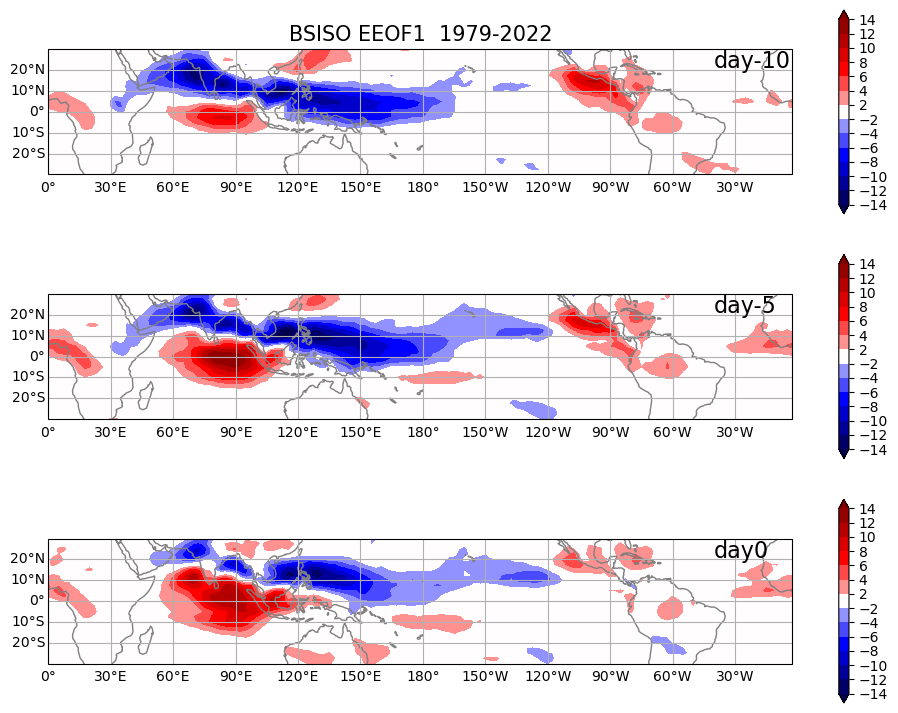

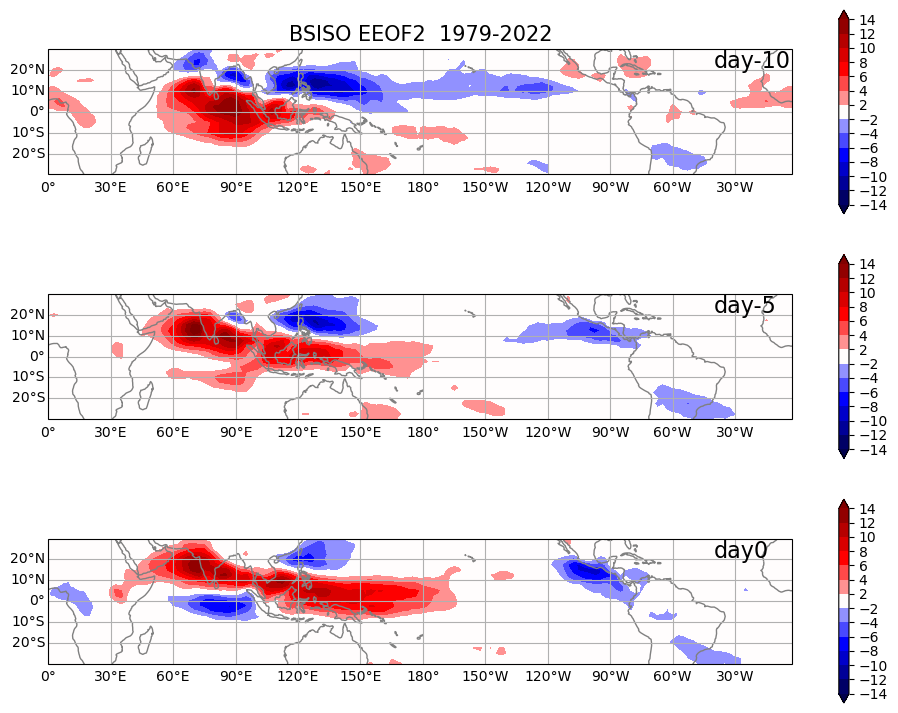

In [64]:
lag = ['day-10', 'day-5', 'day0']
num = [-14, -12, -10, -8, -6, -4, -2, 2, 4, 6, 8, 10, 12, 14]
fig = plt.figure(figsize=(12,9))
for i in range(1,3):
    fig = plt.figure(figsize=(12,9))
    for j in range(1,4):
        ax=fig.add_subplot(3,1,j, projection=ccrs.PlateCarree(central_longitude=180))
        #ax=fig.add_axes((0.05, 0.65-0.25*(j-1), 0.9, 0.3), projection=ccrs.PlateCarree(central_longitude=180))
        ax.set_extent([-180, 177.5, -30, 30], crs=ccrs.PlateCarree())         
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False     # 上部の経度のラベルを消去
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
        gl.ylocator = mticker.FixedLocator(np.arange(-30, 50, 10)) # 緯度線
        ax.coastlines(color='gray')
        # データのプロット
        x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
        cntrf = ax.contourf(x, y, EEOF[i-1,:,:,j-1], num, cmap='seismic', extend='both')
        #cntr = ax.contour(x, y, j[i-1,:,:],np.linspace(-90, 90, num=14), colors='k', linewidths=.5, linestyle='solid')
        ax.axis((-180, 177.5, -30, 30))
        ax.text(140, 24, lag[j-1], fontsize=16, ha='left', va='center')
        cbar = fig.colorbar(cntrf, ticks = num, orientation='vertical')
        if j == 1:
            ax.set_title('BSISO EEOF' + str(i) + '  1979-2022', fontsize=15)

In [9]:
# データをEEOFに射影
df = np.load('/home/maeda/data/bsiso_eeof/eeof.npz')
print(df.files)
EEOF = df['EEOFs'].transpose(1,2,3,0)
EEOF = EEOF.reshape(-1, 25*144, 3)
EEOF = EEOF.reshape(-1, 3600*3)
print(EEOF.shape)
U = df['U']
print(U.shape, EEOF.shape)
rt_PCs = X_total @ U
print(rt_PCs.shape)
rt_PCs_norm = rt_PCs / rt_PCs.std(axis=0)[np.newaxis,:]
print(real_time.shape)

['lon', 'lat', 'time', 'EEOFs', 'PC', 'D', 'V', 's', 'U']
(4038, 10800)
(10800, 10800) (4038, 10800)
(15546, 10800)
(15556,)


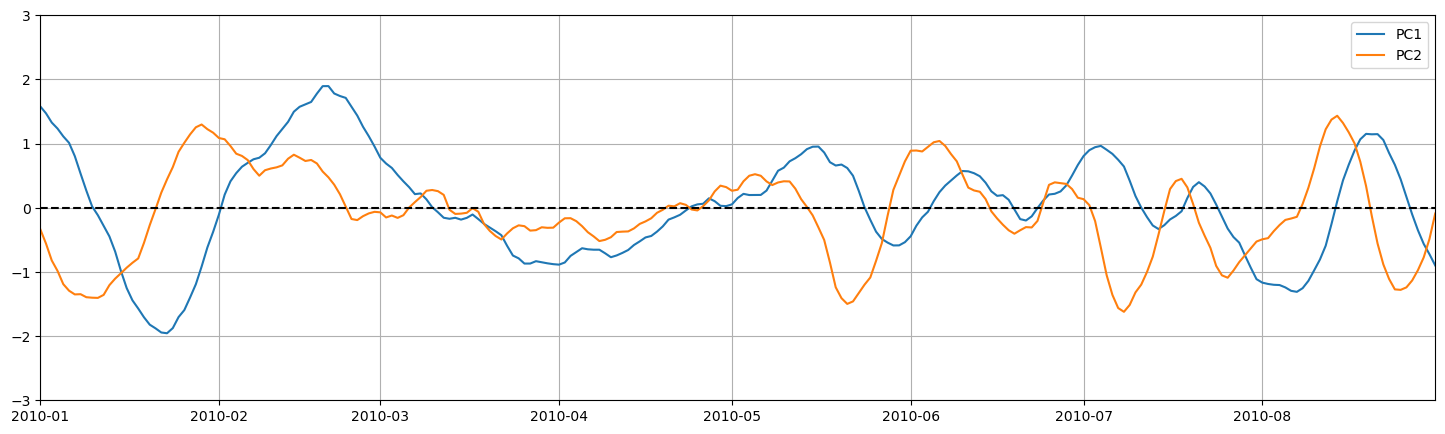

In [15]:
rt = real_time
idx = np.where((rt.year == 2010) & (rt.month <= 8))[0] 
tt = rt[idx]
plt.figure(figsize=(18,5))
plt.plot(tt, -rt_PCs_norm[idx,0])
plt.plot(tt, rt_PCs_norm[idx,1])
plt.hlines(0, tt[0], tt[-1], 'k', linestyle='dashed')
plt.xlim(tt[0], tt[-1])
plt.ylim(-3, 3)
plt.legend(['PC1', 'PC2'])
plt.grid()
plt.show()

In [16]:
np.savez('/home/maeda/data/bsiso_eeof/bsiso_rt-PCs.npz',rt_PCs=rt_PCs[:,:10], time=time)

(4038, 2)
